In [65]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 
from tensorflow import keras
import seaborn as sns
import os 
import warnings 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates    #處理日期
import warnings 

warnings.filterwarnings("ignore")
data = pd.read_csv('./2018_2022/2018_2021_year_stock.csv')

date =data['日期']

# only can run once
for i in range(0,len(date)):
  date.iloc[i]=date.iloc[i].replace(date.iloc[i][0:3], str(int(date.iloc[i][0:3]) + 1911))
print('-'*20)


date=pd.to_datetime(date,format='%Y/%m/%d' ) 
data['日期'] = pd.to_datetime(data['日期'])

# print(data.info())
close_data_ = data['收盤價']
# to_numpy:from dataframe to array
# reshape(-1,1): from 1D array to 2D array
dataset=close_data_.to_numpy().reshape(-1,1)
# print(type(dataset),"dataset資料集:",dataset)
print("-"*20)
training = int(np.ceil(len(dataset) * .95))
# print("traning:",training) #884


# 正規化數值
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# 將資料擴充為二維2D，資料scaled_data的前884個資料
train_data = scaled_data[0:int(training),:]

# 創建自己的dataset
# prepare feature and labels
x_train = []
y_train = []
# labels
# labels的範圍是從60到884，總共824天資料範圍
# X_train 是0~60,1~61,2~62....,824~884
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

x_train,y_train = np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
print(x_train)


--------------------
--------------------
[[[0.23196605]
  [0.2446959 ]
  [0.25176803]
  ...
  [0.28995757]
  [0.28995757]
  [0.30127298]]

 [[0.2446959 ]
  [0.25176803]
  [0.25388967]
  ...
  [0.28995757]
  [0.30127298]
  [0.29349364]]

 [[0.25176803]
  [0.25388967]
  [0.26308345]
  ...
  [0.30127298]
  [0.29349364]
  [0.29278642]]

 ...

 [[0.89886846]
  [0.86845827]
  [0.87411598]
  ...
  [0.7397454 ]
  [0.74328147]
  [0.74611033]]

 [[0.86845827]
  [0.87411598]
  [0.89250354]
  ...
  [0.74328147]
  [0.74611033]
  [0.74398868]]

 [[0.87411598]
  [0.89250354]
  [0.89462518]
  ...
  [0.74611033]
  [0.74398868]
  [0.74611033]]]




## use tensorflow to build LDTM model
創建model，他是sequential類型的網路模型
這個model不是變數，而是sequential 類別生成的物件。請把物件當作幾個變數和函數的集合。Keras透過在model中增加"層"的方式定義網路結構。

首先，這個model增加"全連結層Dense"作為中間層
Dense()的第一個參數的值32是神經元的數量。

In [66]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1],1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary




<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x000001D372D603D0>>

model.compile
optimizier: 這是通過使用梯度下降來幫助優化成本函數的方法。
loss:我們用來監控模型是否隨著訓練而改進的損失函數。

將adam資料傳給compile()，以設定訓練方法。
以均方誤差做為目標函數

model.fit()的參數x_train和y_train用於指定訓練資料，


In [67]:
model.compile(optimizer="adam",loss='mean_squared_error')
history= model.fit(x_train,y_train,epochs=10)

Epoch 1/10
26/26 [==============================] - 13s 64ms/step - loss: 0.0473
Epoch 2/10
26/26 [==============================] - 2s 69ms/step - loss: 0.0156
Epoch 3/10
26/26 [==============================] - 2s 68ms/step - loss: 0.0136
Epoch 4/10
26/26 [==============================] - 2s 65ms/step - loss: 0.0108
Epoch 5/10
26/26 [==============================] - 2s 64ms/step - loss: 0.0107
Epoch 6/10
26/26 [==============================] - 2s 67ms/step - loss: 0.0114
Epoch 7/10
26/26 [==============================] - 2s 60ms/step - loss: 0.0110
Epoch 8/10
26/26 [==============================] - 2s 64ms/step - loss: 0.0092
Epoch 9/10
26/26 [==============================] - 2s 65ms/step - loss: 0.0101
Epoch 10/10
26/26 [==============================] - 2s 62ms/step - loss: 0.0088


為了進行預測，我們需要測試數據，因此我們首先創建測試數據，然後進行模型預測。

In [70]:
test_data = scaled_data[training-60:,:]
x_test = []
y_test = dataset[training:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

x_test = np.array(x_test)
print(x_test)
x_test0 = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(x_test0)


# predict the testing data

predictions = model.predict(x_test0)
print(predictions)
predictions = scaler.inverse_transform(predictions)
# mse: mean square error 平均平方誤差
# y_test is target
# rmse: root mean square error 均方根誤差
mse = np.mean(((predictions - x_test) ** 2))
print("MSE",mse)
print("RMSE",np.sqrt(mse))

def rmse(predictions,targets):
    #valueError: operands could not be broadcast together with shapes (46,1) (46,60,1)
    return np.sqrt(((predictions - targets) ** 2 ).mean())
rmse_val = rmse(predictions,x_test)
print("rms error is: " + str(rmse_val))



[[0.89250354 0.89462518 0.86421499 ... 0.74398868 0.74611033 0.63578501]
 [0.89462518 0.86421499 0.85148515 ... 0.74611033 0.63578501 0.63719943]
 [0.86421499 0.85148515 0.86633663 ... 0.63578501 0.63719943 0.65063649]
 ...
 [0.79420085 0.76732673 0.73620934 ... 0.80975955 0.8125884  0.80905233]
 [0.76732673 0.73620934 0.70650636 ... 0.8125884  0.80905233 0.81541726]
 [0.73620934 0.70650636 0.71499293 ... 0.80905233 0.81541726 0.8281471 ]]
[[[0.89250354]
  [0.89462518]
  [0.86421499]
  ...
  [0.74398868]
  [0.74611033]
  [0.63578501]]

 [[0.89462518]
  [0.86421499]
  [0.85148515]
  ...
  [0.74611033]
  [0.63578501]
  [0.63719943]]

 [[0.86421499]
  [0.85148515]
  [0.86633663]
  ...
  [0.63578501]
  [0.63719943]
  [0.65063649]]

 ...

 [[0.79420085]
  [0.76732673]
  [0.73620934]
  ...
  [0.80975955]
  [0.8125884 ]
  [0.80905233]]

 [[0.76732673]
  [0.73620934]
  [0.70650636]
  ...
  [0.8125884 ]
  [0.80905233]
  [0.81541726]]

 [[0.73620934]
  [0.70650636]
  [0.71499293]
  ...
  [0.8090

我們已經預測了測試數據，讓我們可視化最終結果。

0      25.13
1      25.31
2      25.41
3      25.44
4      25.57
       ...  
879    32.36
880    32.40
881    32.37
882    32.40
883    30.84
Name: 收盤價, Length: 884, dtype: float64 884    31.467371
885    31.303337
886    31.131104
887    30.974773
888    30.859646
889    30.791700
890    30.755154
891    30.760447
892    30.797401
893    30.857996
894    30.963594
895    31.083572
896    31.202538
897    31.296314
898    31.372198
899    31.449471
900    31.533390
901    31.623749
902    31.732195
903    31.837749
904    31.933327
905    31.990656
906    32.019619
907    32.031960
908    32.008308
909    31.955200
910    31.911337
911    31.872551
912    31.854609
913    31.866880
914    31.909405
915    31.978428
916    32.068832
917    32.162846
918    32.254116
919    32.305279
920    32.337002
921    32.387062
922    32.440563
923    32.490402
924    32.529953
925    32.555264
926    32.573261
927    32.580887
928    32.589031
929    32.610916
Name: predictions, dtype: float32


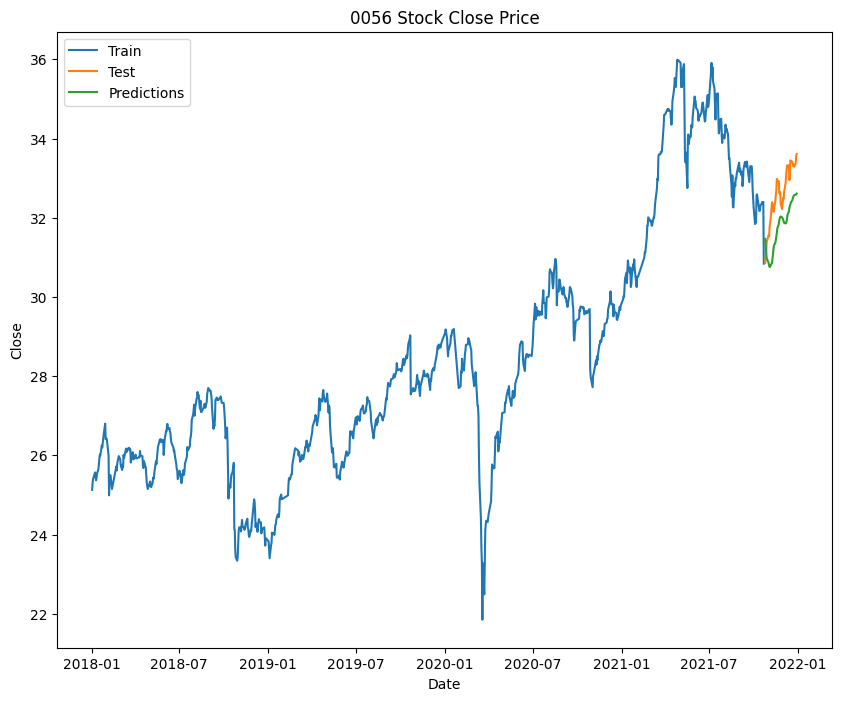

In [71]:
train = data[:training]
test = data[training:]

#train
date = train['日期']
close = train['收盤價']
test['predictions']= predictions
print(close,test['predictions'])
#test
date_ = test['日期']
close_ = test[['收盤價',"predictions"]]
plt.figure(figsize=(10,8))
plt.plot(date,close)
plt.plot(date_,close_)
plt.title("0056 Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(['Train','Test','Predictions'])